#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [156]:
## 공통
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
## 공통
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [158]:
## 공통
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, LSTM, Conv1D
from keras.backend import clear_session
from keras.optimizers import Adam

## 추가
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [159]:
## 공통
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [160]:
## 공통
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')
feature = pd.read_csv(path + 'features.csv')

In [161]:
## 공통
# 불필요한 칼럼을 삭제하세요.
train_data = train_data.drop('subject', axis=1)
test_data = test_data.drop('subject', axis=1)

#### 2) 기본 정보 조회

In [162]:
## 공통
# 전체 데이터의 행,열 개수 확인
print(train_data.shape)
print(test_data.shape)

(5881, 562)
(1471, 562)


In [163]:
## 공통
# 전체 데이터의 상위 5개 행 확인
display(train_data.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,-0.554597,-0.792535,0.848680,0.681264,0.830280,-0.972192,-0.999869,-0.999481,-0.999037,-0.989127,-0.967796,-0.961417,-0.273898,-0.251856,-0.317703,0.152665,-0.094784,0.013173,-0.021494,-0.109208,-0.011862,0.247912,-0.163137,-0.049915,0.039451,0.004133,-0.107632,0.410771,0.359068,0.830987,...,-0.985141,-1.000000,-0.968254,0.151730,-0.752862,-0.947449,-0.975435,-0.971340,-0.967392,-0.973365,-0.997910,-0.975435,-0.999448,-0.975187,-0.586855,-0.948718,-0.248487,-0.381800,-0.686723,-0.987289,-0.987733,-0.985201,-0.989966,-0.993965,-0.987289,-0.999881,-0.983540,-0.792601,-0.968254,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,-0.573949,-0.813137,0.839654,0.694376,0.845888,-0.988936,-0.999873,-0.999973,-0.999605,-0.991301,-0.993293,-0.988185,-0.703003,-0.698294,-0.360379,0.006580,-0.052478,0.077635,-0.045803,0.464764,-0.311399,0.447480,-0.081991,0.005108,0.058604,0.109332,-0.240013,-0.471294,-0.372938,-0.084398,...,-0.988982,-1.000000,-0.841270,0.468130,-0.612265,-0.892018,-0.978534,-0.975336,-0.970352,-0.980430,-0.996718,-0.978534,-0.999576,-0.972738,-0.580951,-0.948718,-0.288496,-0.536373,-0.832824,-0.987308,-0.985599,-0.985495,-0.988647,-0.994733,-0.987308,-0.999866,-0.991207,-0.809976,-1.000000,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,-0.566451,-0.822908,0.851978,0.681985,0.845253,-0.994235,-0.999988,-0.999847,-0.999905,-0.997938,-0.986461,-0.995140,-0.728912,-0.481285,-0.619015,0.491210,-0.226718,0.287611,0.026310,0.301165,-0.173546,0.470998,-0.291421,0.562884,-0.186600,0.319862,0.046782,-0.050555,0.107324,-0.138813,...,-0.991535,-1.000000,-0.523810,0.640565,-0.776604,-0.925004,-0.991953,-0.993282,-0.992181,-0.99

In [164]:
## 공통
# 전체 데이터의 수치형 변수 분포 확인
display(train_data.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,-0.305598,-0.556708,0.522007,0.386354,0.593807,-0.545782,-0.819172,-0.902021,-0.845738,-0.681739,-0.643437,-0.629983,-0.099776,-0.135900,-0.162285,-0.117435,0.104057,-0.039662,0.132872,-0.026011,0.026873,0.159336,-0.018327,0.009966,0.033424,0.037016,-0.078399,-0.126412,-0.194947,0.106897,...,-0.840820,-0.677162,-0.343444,-0.879002,0.176935,-0.310519,-0.613189,-0.693150,-0.693065,-0.675303,-0.726602,-0.885129,-0.693150,-0.874650,-0.720197,-0.086690,-0.887809,-0.042947,-0.256063,-0.568061,-0.778501,-0.791450,-0.772051,-0.810321,-0.870934,-0.778501,-0.935658,-0.770966,-0.281750,-0.898311,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,0.280900,0.292853,0.363008,0.343224,0.296391,0.471427,0.259423,0.125469,0.220782,0.372289,0.370685,0.385966,0.468436,0.436310,0.371925,0.307025,0.247142,0.243794,0.228424,0.257119,0.21532

In [165]:
## 공통
# 전체 데이터의 모든 변수 확인
print(train_data.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [166]:
## 공통
# 데이터 분할을 합니다.
x = train_data.drop('Activity', axis=1)
y = train_data['Activity']

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

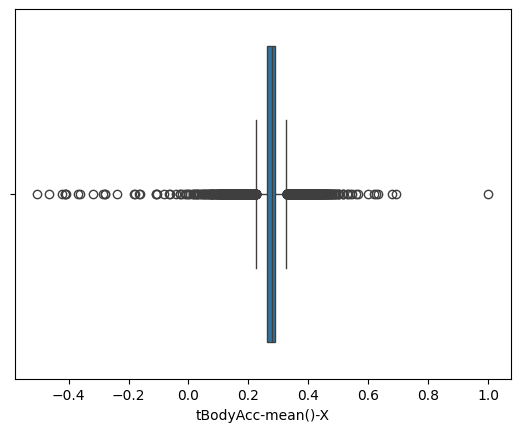

In [167]:
"""
GPT:
이상치에 민감, 이상치가 제거된 데이터 -> MinMaxScaler
이상치에 덜 민감, 이상치가 포함되어도 상관없음 -> StandardScaler

다음 boxplot 그래프와 같이 이상치가 많으므로 StandardScaler를 사용
"""
sns.boxplot(x='tBodyAcc-mean()-X', data=train_data)
plt.show()

# 스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = StandardScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [168]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

## 정수형 클래스를 원 핫 인코딩
y = to_categorical(y)

[2 0 2 ... 0 5 1]


In [169]:
# 기존 레이블 저장
## 라벨 -> 숫자
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
## 숫자 → 라벨
reverse_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# 확인
print("레이블 → 숫자:", label_mapping)
print("숫자 → 레이블:", reverse_mapping)

레이블 → 숫자: {'LAYING': np.int64(0), 'SITTING': np.int64(1), 'STANDING': np.int64(2), 'WALKING': np.int64(3), 'WALKING_DOWNSTAIRS': np.int64(4), 'WALKING_UPSTAIRS': np.int64(5)}
숫자 → 레이블: {np.int64(0): 'LAYING', np.int64(1): 'SITTING', np.int64(2): 'STANDING', np.int64(3): 'WALKING', np.int64(4): 'WALKING_DOWNSTAIRS', np.int64(5): 'WALKING_UPSTAIRS'}


### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [170]:
# 데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [171]:
# 모델 설계
n_feature = x_train.shape[1]
n_class = y.shape[1]
"""
onehot 인코딩으로 output 크기가 유니크한 클래스의 수로 변경
"""

model_1 = Sequential([
    Dense(n_class, input_dim=n_feature, activation='softmax')
])

model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [172]:
# 컴파일 및 학습
model_1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6072 - loss: 0.9992 - val_accuracy: 0.9286 - val_loss: 0.2571
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9317 - loss: 0.2402 - val_accuracy: 0.9439 - val_loss: 0.1800
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9548 - loss: 0.1661 - val_accuracy: 0.9558 - val_loss: 0.1397
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9651 - loss: 0.1278 - val_accuracy: 0.9567 - val_loss: 0.1287
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9692 - loss: 0.1074 - val_accuracy: 0.9711 - val_loss: 0.1035
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9765 - loss: 0.0889 - val_accuracy: 0.9737 - val_loss: 0.0962
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9763 - loss: 0.0869 - val_accuracy: 0.9771 - val_loss: 0.0876
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.0771 - val_accuracy: 0.

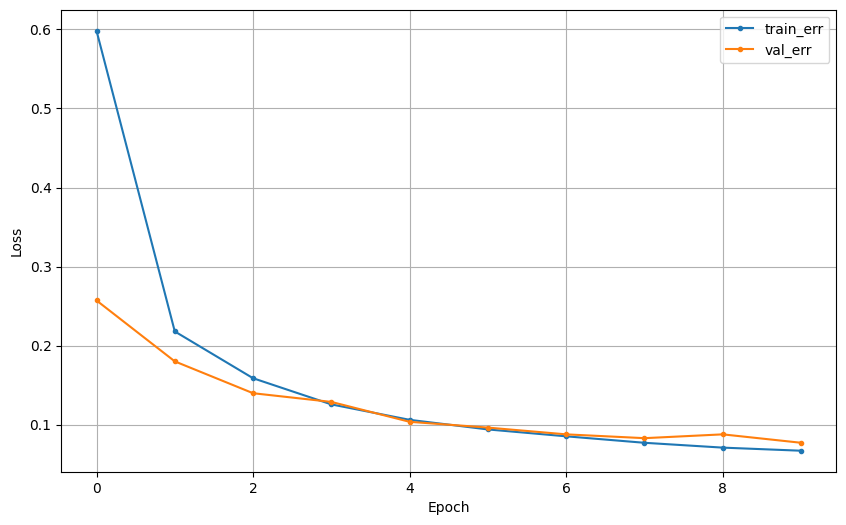

In [174]:
# 학습곡선
dl_history_plot(history_1.history)

In [175]:
# 예측 및 평가
y_pred_1 = model_1.predict(x_val)
y_pred_1 = np.argmax(y_pred_1, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred_1, target_names=le.classes_))
print('-'*100)
print(accuracy_score(np.argmax(y_val, axis=1), y_pred_1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.92      0.97      0.94       200
          STANDING       0.98      0.92      0.95       226
           WALKING       1.00      0.99      0.99       198
WALKING_DOWNSTAIRS       0.99      1.00      1.00       145
  WALKING_UPSTAIRS       0.99      1.00      1.00       177

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177

----------------------------------------------------------------------------------------------------
0.9787595581988106


In [176]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
acc_list = [
    0.9830076465590484,
    0.9787595581988106,
    0.9813084112149533,
    0.9787595581988106,
    0.9813084112149533,
    ]

print(f'Accuracy mean : {np.array(acc_list).mean()}')

Accuracy mean : 0.9806287170773151


### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [177]:
# 모델 설계
model_2 = Sequential([
    Dense(128, input_dim=n_feature, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(n_class, activation='softmax')
])

model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

In [178]:
# 컴파일 및 학습
model_2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model_2.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6561 - loss: 0.8904 - val_accuracy: 0.9541 - val_loss: 0.1316
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9509 - loss: 0.1270 - val_accuracy: 0.9686 - val_loss: 0.0877
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9720 - loss: 0.0784 - val_accuracy: 0.9686 - val_loss: 0.0955
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9793 - loss: 0.0622 - val_accuracy: 0.9754 - val_loss: 0.0610
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9772 - loss: 0.0623 - val_accuracy: 0.9728 - val_loss: 0.0720
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9760 - loss: 0.0659 - val_accuracy: 0.9694 - val_loss: 0.0828
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9863 - loss: 0.0388 - val_accuracy: 0.9830 - val_loss: 0.0577
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9906 - loss: 0.0292 - val_accuracy: 0.

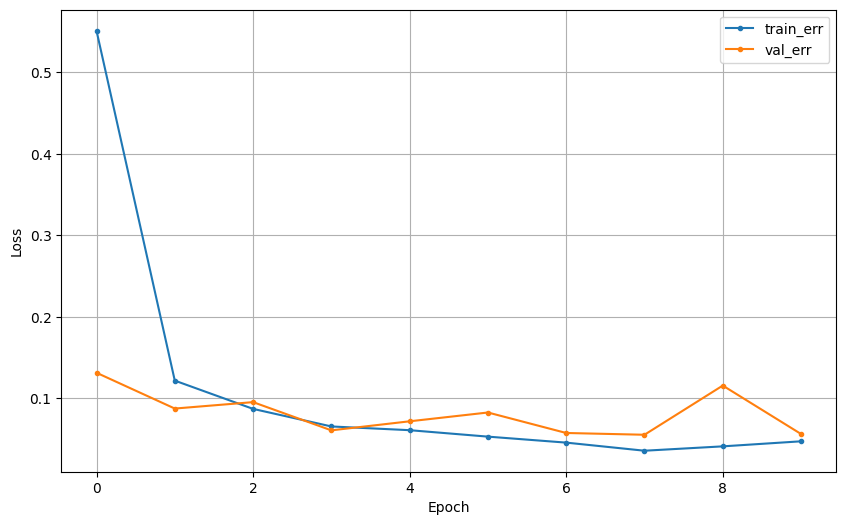

In [179]:
# 학습곡선
dl_history_plot(history_2.history)

In [180]:
# 예측 및 평가
y_pred_2 = model_2.predict(x_val)
y_pred_2 = np.argmax(y_pred_2, axis=1)

print(classification_report(np.argmax(y_val, axis=1), y_pred_2, target_names=le.classes_))
print('-'*100)
print(accuracy_score(np.argmax(y_val, axis=1), y_pred_2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.96      0.96      0.96       200
          STANDING       0.96      0.96      0.96       226
           WALKING       1.00      0.97      0.99       198
WALKING_DOWNSTAIRS       1.00      0.99      1.00       145
  WALKING_UPSTAIRS       0.97      1.00      0.98       177

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177

----------------------------------------------------------------------------------------------------
0.9813084112149533


### (3) 모델3 : 학습률, epoch 등 조정

In [181]:
## 시계열 데이터 셋에 사용 -> 2차원을 3차원으로 !
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

In [182]:
## 시계열 데이터로 변경
x_train_Seq, y_train_Seq = temporalize(x_train, y_train, 50)
x_val_Seq, y_val_Seq = temporalize(x_val, y_val, 50)

In [183]:
# 모델 설계
model_3 = Sequential([
    LSTM(units=128, input_shape=(x_train_Seq.shape[1], x_train_Seq.shape[2])),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(n_class, activation='softmax')
])

model_3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │       353,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,758 (1.45 MB)

 Trainable params: 380,758 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [184]:
## EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',         # 검증 손실 기준으로 조기 종료
    patience=3,                 # 개선되지 않을 경우 10 Epoch 후 종료
    restore_best_weights=True   # 가장 좋은 가중치로 복원
)

# 컴파일 및 학습
model_3.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3 = model_3.fit(x_train_Seq, y_train_Seq, epochs=20, batch_size=16, validation_data=(x_val_Seq, y_val_Seq), callbacks=early_stopping)

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6458 - loss: 0.8401 - val_accuracy: 0.9530 - val_loss: 0.1322
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9487 - loss: 0.1272 - val_accuracy: 0.9548 - val_loss: 0.1198
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9675 - loss: 0.0889 - val_accuracy: 0.9495 - val_loss: 0.1322
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9766 - loss: 0.0671 - val_accuracy: 0.9796 - val_loss: 0.0708
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9858 - loss: 0.0422 - val_accuracy: 0.9823 - val_loss: 0.0621
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9838 - loss: 0.0408 - val_accuracy: 0.9495 - val_loss: 0.1700
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9715 - loss: 0.0835 - val_accuracy: 0.9530 - val_loss: 0.1421
Epoch 8/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9763 - loss: 0.0583 - val_accuracy: 

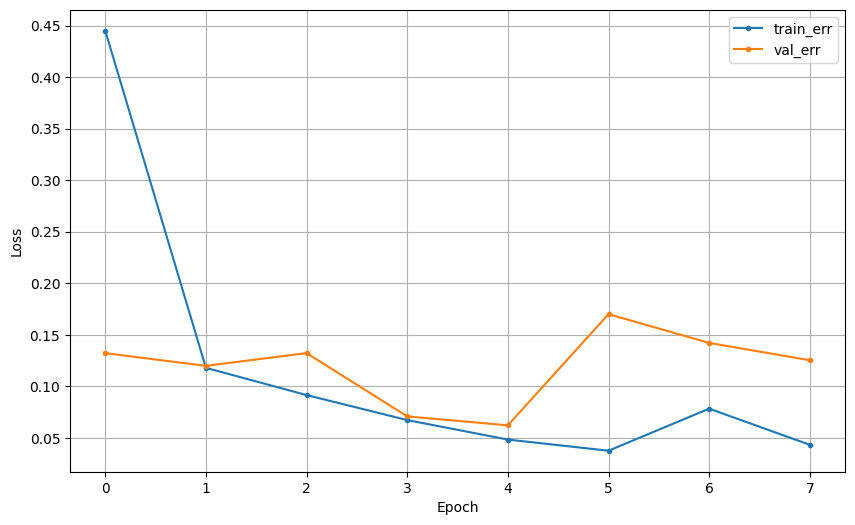

In [185]:
# 학습곡선
dl_history_plot(history_3.history)

In [187]:
# 예측 및 평가
y_pred_3 = model_3.predict(x_val_Seq)
y_pred_3 = np.argmax(y_pred_3, axis=1)

print(classification_report(np.argmax(y_val_Seq, axis=1), y_pred_3, target_names=le.classes_))
print('-'*100)
print(accuracy_score(np.argmax(y_val_Seq, axis=1), y_pred_3))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       221
           SITTING       0.96      0.96      0.96       190
          STANDING       0.96      0.96      0.96       219
           WALKING       1.00      0.98      0.99       188
WALKING_DOWNSTAIRS       1.00      1.00      1.00       139
  WALKING_UPSTAIRS       0.98      0.99      0.99       171

          accuracy                           0.98      1128
         macro avg       0.98      0.98      0.98      1128
      weighted avg       0.98      0.98      0.98      1128

----------------------------------------------------------------------------------------------------
0.9822695035460993


### (4) 모델4 :  학습률, epoch 등 조정

In [188]:
# 모델 설계
model_4 = Sequential([
    LSTM(units=64, input_shape=(x_train_Seq.shape[1], x_train_Seq.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(units=128),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(n_class, activation='softmax')
])

model_4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50, 64)         │       160,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,038 (1.03 MB)

 Trainable params: 270,038 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [189]:
# 컴파일 및 학습
model_4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4 = model_4.fit(x_train_Seq, y_train_Seq, epochs=20, batch_size=64, validation_data=(x_val_Seq, y_val_Seq), callbacks=early_stopping)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2531 - loss: 1.6506 - val_accuracy: 0.7855 - val_loss: 0.6890
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7507 - loss: 0.5889 - val_accuracy: 0.9122 - val_loss: 0.2462
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8719 - loss: 0.2814 - val_accuracy: 0.9309 - val_loss: 0.1667
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9310 - loss: 0.1729 - val_accuracy: 0.9654 - val_loss: 0.0971
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9532 - loss: 0.1255 - val_accuracy: 0.9672 - val_loss: 0.0857
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9643 - loss: 0.0958 - val_accuracy: 0.9787 - val_loss: 0.0646
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9646 - loss: 0.0963 - val_accuracy: 0.9778 - val_loss: 0.0653
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9702 - loss: 0.0859 - val_accuracy: 0.9610 - v

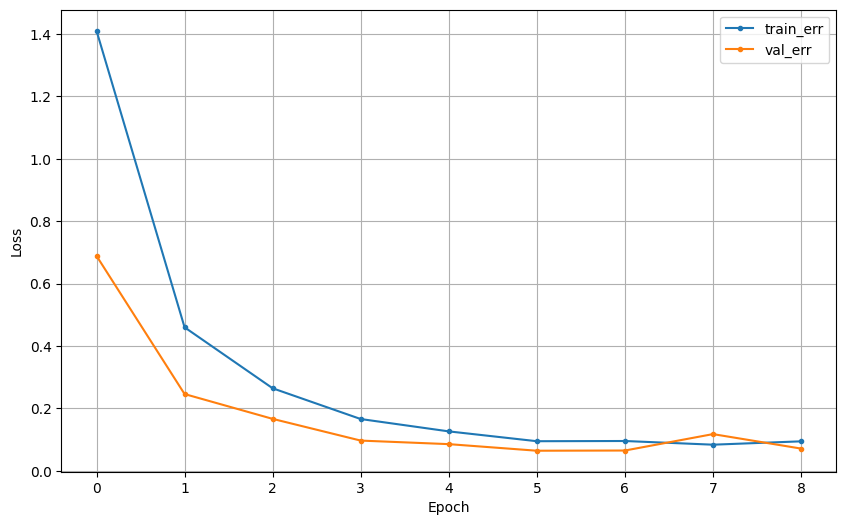

In [190]:
# 학습곡선
dl_history_plot(history_4.history)

In [191]:
# 예측 및 평가
y_pred_4 = model_4.predict(x_val_Seq)
y_pred_4 = np.argmax(y_pred_4, axis=1)

print(classification_report(np.argmax(y_val_Seq, axis=1), y_pred_4, target_names=le.classes_))
print('-'*100)
print(accuracy_score(np.argmax(y_val_Seq, axis=1), y_pred_4))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       221
           SITTING       0.97      0.93      0.95       190
          STANDING       0.94      0.97      0.96       219
           WALKING       1.00      0.99      0.99       188
WALKING_DOWNSTAIRS       0.99      0.99      0.99       139
  WALKING_UPSTAIRS       0.98      1.00      0.99       171

          accuracy                           0.98      1128
         macro avg       0.98      0.98      0.98      1128
      weighted avg       0.98      0.98      0.98      1128

----------------------------------------------------------------------------------------------------
0.9787234042553191


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [192]:
#전체 데이터 불러오기(test)
test_data = pd.read_csv(path + 'data01_test.csv')

# subject 삭제
test_data = test_data.drop('subject', axis=1)

# x, y 분할
x_2 = test_data.drop('Activity', axis=1)
y_2 = test_data['Activity']

# 스케일링
# x : 스케일링 적용
x_test_scaled = scaler.transform(x_2)


# y : 정수인코딩 적용
y_test_encoded = le.transform(y_2)
y_test_onehot = to_categorical(y_test_encoded)

In [193]:
## 3차원 LSTM 사용
x_test_Seq, y_test_Seq = temporalize(x_test_scaled, y_test_onehot, 50)

In [195]:
# test 데이터에 대한 성능 측정
model_1.evaluate(x_test_scaled, y_test_onehot)
model_2.evaluate(x_test_scaled, y_test_onehot)
model_3.evaluate(x_test_Seq, y_test_Seq)
model_4.evaluate(x_test_Seq, y_test_Seq)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9711 - loss: 0.0825
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9685 - loss: 0.0987
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9737 - loss: 0.0637
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9650 - loss: 0.1068


[0.1037391871213913, 0.9620253443717957]

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.